In [1]:
import matplotlib.pyplot as plt

In [2]:
from yahoofinancials import YahooFinancials as yf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# models 
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

import pandas_datareader.data as reader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# %matplotlib inline
# dependencies 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from mlens.ensemble import SuperLearner


[MLENS] backend: threading


In [3]:
def get_stock_data(tickers, start_date=None, end_date=None, freq='daily'):
    ticker_not_found=[]
    for ticker in tickers:
        yf_engine = yf(ticker)
        price = yf_engine.get_historical_price_data(start_date,end_date,freq)
        #store the data in DataFrame
        try:
            print('before',ticker)
            ticker_data = pd.DataFrame(price[ticker]['prices'])
            print('after',ticker_data)
            ticker_data = ticker_data.drop('date', axis=1) # We will use formatted_date columns instead
        except:
            ticker_not_found.append(ticker)
            continue
            
    return ticker_data, ticker_not_found

In [4]:
ticker = ['TSLA']
start_date = '2010-09-01'
end_date = '2021-11-19'


import pandas_datareader.data as reader
data = reader.get_data_yahoo('TSLA')
df = data.reset_index()
df1=df.copy()

df, ticker_not_found = get_stock_data(ticker, start_date, end_date)

before TSLA
after             date         high          low         open        close  \
0     1283347800     4.138000     3.920000     3.924000     4.090000   
1     1283434200     4.248000     4.062000     4.074000     4.212000   
2     1283520600     4.260000     4.132000     4.174000     4.210000   
3     1283866200     4.200000     4.100000     4.122000     4.108000   
4     1283952600     4.190000     4.120000     4.132000     4.180000   
...          ...          ...          ...          ...          ...   
2820  1636727400  1054.500000  1019.200012  1047.500000  1033.420044   
2821  1636986600  1031.979980   978.599976  1017.630005  1013.390015   
2822  1637073000  1057.199951  1002.179993  1003.309998  1054.729980   
2823  1637159400  1119.640015  1055.500000  1063.510010  1089.010010   
2824  1637245800  1112.000000  1075.020020  1106.550049  1096.380005   

        volume     adjclose formatted_date  
0      2474500     4.090000     2010-09-01  
1      2435500     4.212000

In [7]:
def get_clean_data (df, start_date, end_date):
    features = df.copy()
    features = features.drop(['formatted_date'], axis=1)
    #creating features as stated above
    features['volume'] = features['volume'].shift(1)
    features['SMA'] = features['adjclose'].rolling(window=20).mean().shift(1)
    features['Std_20'] = features['adjclose'].rolling(window=20).std().shift(1)
    features['Band_1'] = features['SMA'] - features['Std_20']
    features['Band_2'] = features['SMA'] + features['Std_20']
    features['ON_returns'] = features['close'] - features['open'].shift(-1)
    features['ON_returns'] = features['ON_returns'].shift(1)
    features['ON_returns_signal'] = np.where(features['ON_returns']<0, 'up', 'down')
    features['dist_from_mean'] = features['adjclose'].shift(1) - features['SMA']
    
  #Obtaining Vix Data and combining with existing features of stock
    ticker = ['^VIX']
    start_date = start_date
    end_date = end_date
    vix_data, ticker_not_found = get_stock_data(ticker, start_date, end_date)
    vix_data = pd.DataFrame(vix_data['adjclose'].shift(1))
    vix_data = vix_data.rename(columns = {'adjclose':'vix_data'})
    comb_features = pd.concat([features,vix_data], axis=1)
    comb_features = comb_features.dropna() #dropping NaN values
    comb_features = pd.get_dummies(comb_features, columns=['ON_returns_signal']) #for categorical variables
    comb_features = comb_features.drop('ON_returns', axis=1) #dropping original categorical column
    comb_features = comb_features.drop('close', axis=1) #not really needed this value since we have adj close now  
    ###Create return column to predict
    comb_features['stock_move'] = np.where(comb_features['adjclose']-
                                           comb_features['adjclose'].shift(-1)<0, "Buy", "Sell")
    features_clean = comb_features.dropna() #Dropping Nan values
    features_clean = features_clean[:-1] #Drop last row which do not have any stock signal
    features_clean.tail()
    return features_clean

In [8]:
# np.random.seed(42)
features = get_clean_data(df, start_date, end_date)

before ^VIX
after             date       high        low       open      close  volume  \
0     1283347800  25.129999  23.860001  25.129999  23.889999       0   
1     1283434200  24.309999  23.150000  24.230000  23.190001       0   
2     1283520600  22.780001  21.240000  21.990000  21.309999       0   
3     1283866200  23.940001  22.770000  22.770000  23.799999       0   
4     1283952600  23.559999  22.920000  23.510000  23.250000       0   
...          ...        ...        ...        ...        ...     ...   
2820  1636727400  17.690001  16.150000  17.490000  16.290001       0   
2821  1636986600  17.459999  16.490000  17.030001  16.490000       0   
2822  1637073000  17.080000  16.030001  16.860001  16.370001       0   
2823  1637159400  17.190001  16.280001  16.360001  17.110001       0   
2824  1637245800  18.150000  16.379999  16.809999  17.590000       0   

       adjclose formatted_date  
0     23.889999     2010-09-01  
1     23.190001     2010-09-02  
2     21.309999   

In [9]:
features.head()
#convert stock_move to binary
features['stock_move'] = np.where(features['stock_move'] == 'Sell', 0, 1)
# Split Data 
X = features.drop(['high', 'low', 'stock_move'], axis=1)
y = features['stock_move']


#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Scale Our Data

#Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# create a list of base-models
def get_models():
    models = list()
    models.append(LogisticRegression(solver='liblinear'))
    models.append(DecisionTreeClassifier())
    models.append(SVC(gamma='scale', probability=True))
    models.append(GaussianNB())
    models.append(KNeighborsClassifier())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier(n_estimators=100))
    models.append(RandomForestClassifier(n_estimators=100))
    models.append(ExtraTreesClassifier(n_estimators=100))
    return models
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
    # define split of data
    kfold = KFold(n_splits=10, shuffle=True)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X):
        fold_yhats = list()
        # get data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        meta_y.extend(y_test)
        # fit and make predictions with each sub-model
        for model in models:
            model.fit(X_train, y_train)
            yhat = model.predict_proba(X_test)
            # store columns
            fold_yhats.append(yhat)
        # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)
# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)
# fit a meta model
def fit_meta_model(X, y):
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    return model

In [11]:
# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    for model in models:
        yhat = model.predict(X)
        acc = accuracy_score(y, yhat)
        print('%s: %.3f' % (model.__class__.__name__, acc*100))
# make predictions w/ stacked model
def super_learner_predictions(X, models, meta_model):
    meta_X = list()
    for model in models:
        yhat = model.predict_proba(X)
        meta_X.append(yhat)
    meta_X = hstack(meta_X)
    # predict
    return meta_model.predict(meta_X)

In [12]:
from sklearn.model_selection import KFold
from numpy import hstack
from numpy import vstack
from numpy import asarray
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X_train, y_train, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_test, y_test, models)
# evaluate meta model
yhat = super_learner_predictions(X_test, models, meta_model)
print('Super Learner Accuracy: %.3f' % (accuracy_score(y_test, yhat) * 100))

Meta  (1962, 18) (1962,)
LogisticRegression: 49.287
DecisionTreeClassifier: 50.831
SVC: 49.169
GaussianNB: 49.169
KNeighborsClassifier: 49.169
AdaBoostClassifier: 49.169
BaggingClassifier: 49.169
RandomForestClassifier: 49.169
ExtraTreesClassifier: 51.544
Super Learner Accuracy: 49.169


<AxesSubplot:>

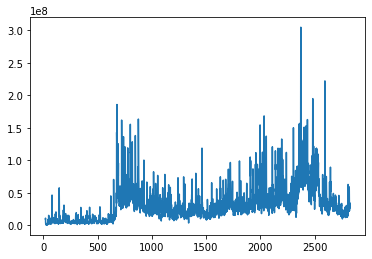

In [13]:
features['volume'].plot()

<AxesSubplot:>

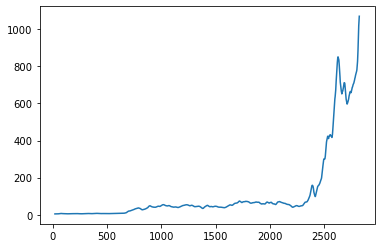

In [14]:
features['SMA'].plot()

<AxesSubplot:>

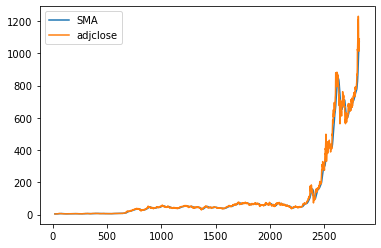

In [15]:
features[['SMA','adjclose']].plot()

<AxesSubplot:>

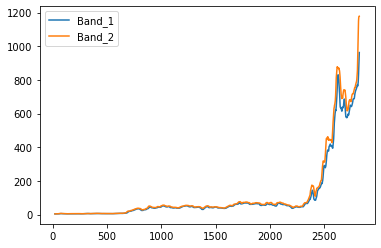

In [16]:
features[['Band_1','Band_2']].plot()

In [17]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "SGD Classifier": SGDClassifier(), 
         "SVM": svm.SVC(kernel = 'rbf')}
# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    
    print('classification Accuracy')
    return model_scores

In [18]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

classification Accuracy


{'KNN': 0.5106888361045131,
 'Logistic Regression': 0.4916864608076009,
 'Random Forest': 0.5225653206650831,
 'SGD Classifier': 0.4916864608076009,
 'SVM': 0.48931116389548696}

<AxesSubplot:>

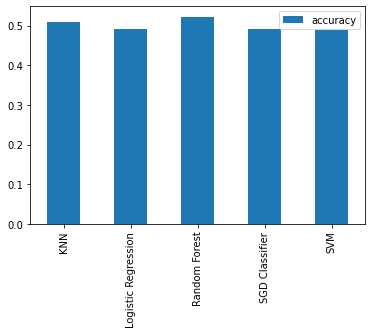

In [19]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar()

In [20]:
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [21]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rfc = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=10,
                            verbose=True)
 

# Fit random hyperparameter search model
rfc.fit(X_train, y_train);


Fitting 5 folds for each of 10 candidates, totalling 50 fits


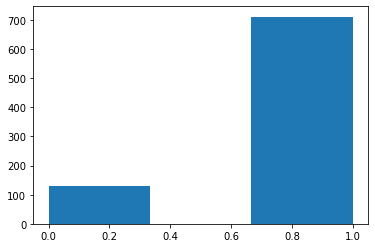

In [ ]:
y_pred = rfc.predict(X_test)
plt.hist(y_pred, bins=3);


Accuracy score of the model is:  0.48812351543942994


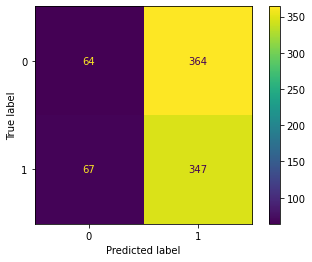

In [ ]:
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(rfc, X_test, y_test);